In [1]:
# calculate the linear regression for each gridpoint and mean over the areas from the mask function
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
# import xclim as xc
import os
from matplotlib import rcParams
from memory_profiler import profile
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import pandas as pd
from matplotlib import rcParams
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi
import os
from memory_profiler import profile
import scipy.stats as stats
import scipy.signal as signal
import Calculation.mask_creation as mc

# from cartopy.mpl.geoaxes import GeoAxes
# GeoAxes._pcolormesh_patched = Axes.pcolormesh

homefolder = '/home/nniebaum/data_nils'
datafolder = '/data/user/nniebaum'
plotfolder = '/home/nniebaum/bachlor-thesis-code/Plots/'
areafolder = plotfolder + "Area/"
populationfolder = plotfolder + "Population/"


plt.rcParams.update(plotfunc.rcParams_area)
plt.rcParams.update({'hatch.linewidth': 2})

import scipy.ndimage as ndimage
filter_func = lambda y : ndimage.gaussian_filter(y, sigma=2.0, truncate=2.0, mode='constant', cval=np.nan)
filter_name = "gauss"

In [2]:
# load data
st = time.time()
data = xr.open_dataset(datafolder + '/europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')

regions = [("EUR", None),('NEU', 16), ('CEU', 17) , ('EEU' , 18), ('MED' , 19) ]

print(time.time() - st)
data

0.03143739700317383


<xarray.Dataset>
Dimensions:                       (bnds: 2, latitude: 39, longitude: 56, quantile: 3, time: 40542)
Coordinates:
  * time                          (time) datetime64[ns] 1900-01-01T09:00:00 ....
  * longitude                     (longitude) float32 -14.625 -13.5 ... 47.25
  * latitude                      (latitude) float32 74.25 73.125 ... 31.5
  * quantile                      (quantile) float64 0.9 0.95 0.98
Dimensions without coordinates: bnds
Data variables:
    time_bnds                     (time, bnds) datetime64[ns] ...
    swbgt                         (time, latitude, longitude) float32 ...
    t2m                           (time, latitude, longitude) float32 ...
    d2m                           (time, latitude, longitude) float32 ...
    t2m_mask_quantiles            (time, latitude, longitude, quantile) int8 ...
    t2m_mask_ydrunpctl            (time, latitude, longitude) bool ...
    area                          (latitude, longitude) float64 ...
    population_total              (latitude, longitude) float32 ...
    mask_land                     (latitude, longitude) int8 ...
    heatwave_mask                 (time, latitude, longitude) int8 ...
    heatwave_mask_25degthreshold  (time, latitude, longitude) int8 ...
    heatwave_mask_ydrunpctl       (time, latitude, longitude) bool ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Nov 01 16:28:14 2020: cdo daymax europe_full_1900-01-01...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

**Plot the histograms of swbgt for heatday definitions**

In [3]:
# ================== HISTOGRAMMS =================




duration = 3
min_count = 3
variable = "t2m"
variable_long = "temperature in °C"

st = time.time()
mask_duration = hwi.calc_heatwave_index(data.heatwave_mask, duration = duration)
print(time.time() - st)

# data['heatwave_mask'] = mask_dwd
# data.heatwave_mask.attrs = dict(long_name = 'mask of heatwave days',
#                                 definition= 'Defined as 25°C threshold, 98 percentile of temperature and min. 3 days duration (similar to DWD definition)',
#                                 threshold = threshold,
#                                 duration = duration,
#                                 quantile = quantile)
# data.to_netcdf(data_folder + 'heatwave_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')

8.423057317733765


/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


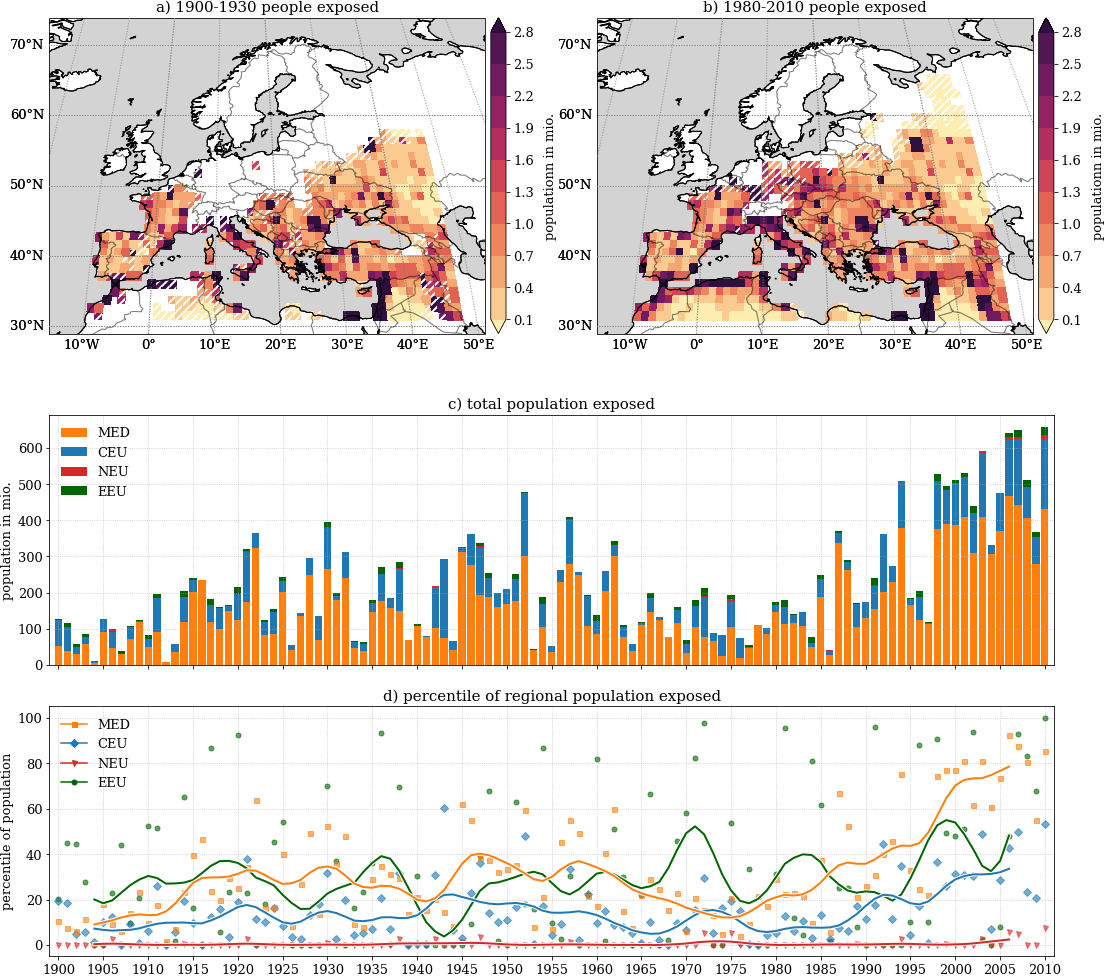

In [5]:
# import cartopy

min_yearlydays = 3
quantile_sWBGT = 0.98
min_years = 5
min_years_low = 1
title_first30 = "a) 1900-1930 people exposed"
title_last30 = "b) 1980-2010 people exposed"
middle_title = "c) total population exposed"
lower_title = "d) percentile of regional population exposed"
suptitle = "population exposed to heatwave\nat least {:.0f} heatwave days per year and {:.0f} percentile of sWBGT\nfor a) and b) if at least {:.0f} years with above conditions occure\n for a) and b) hatched if at least {:.0f} years with above conditions occure".format(min_yearlydays, quantile_sWBGT * 100, min_years, min_years_low)
savename = "population_exposed_{:.0f}mindays_{:.0f}percsWBGT_{:.0f}years".format(min_yearlydays, quantile_sWBGT * 100, min_years)

mask = mask_duration & (data.swbgt >= data.swbgt.quantile(quantile_sWBGT, dim = 'time'))
mask = (mask.groupby("time.year").sum('time')) >= min_yearlydays
# print(mask)

xmin = 1899
xmax = 2011

fig = plt.figure(figsize = (18,18))
gs = gridspec.GridSpec(7,2, hspace = 0.4)
# plt.suptitle(suptitle, y = 0.94)

# first 30 years
timeslice = slice('1900','1931')
ax0 = fig.add_subplot(gs[0:3, 0],\
    projection=ccrs.EckertV(central_longitude=12.5))
plotfunc.area_plot(pcolormesh = False,  pcolor = True, ax = ax0, data = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") >= min_years*0.5), 
                   cmap = 'cmo.matter',levels = np.arange(0.1,3,0.3), 
                   colorbar_kwargs = dict(add_colorbar = False), 
                   pcolormesh_kwargs = dict(alpha = 1, hatch= '///'))
plotfunc.area_plot(ax = ax0, data = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") > min_years), 
                   cmap = 'cmo.matter', levels = np.arange(0.1,3,0.3), 
                   colorbar_kwargs = dict(label = "populationn in mio."),
                   landcolor= False)
ax0.set_title(title_first30)

# last 30 years
timeslice = slice('1980','2010')
ax1 = fig.add_subplot(gs[0:3, 1],\
    projection=ccrs.EckertV(central_longitude=12.5))
plotfunc.area_plot(pcolormesh = False,  pcolor = True, ax = ax1, data = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") >= min_years*0.5), 
                   cmap = 'cmo.matter',levels = np.arange(0.1,3,0.3), 
                   colorbar_kwargs = dict(add_colorbar = False), 
                   pcolormesh_kwargs = dict(alpha = 1, hatch= '///'))
plotfunc.area_plot(ax = ax1, data = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") > min_years), 
                   cmap = 'cmo.matter', levels = np.arange(0.1,3,0.3), 
                   colorbar_kwargs = dict(label = "populationn in mio."),
                   landcolor= False)

# ax.add_feature(cartopy.feature.BORDERS, zorder = 10, color = "k", alpha = 0.5)
ax1.set_title(title_last30)


ax2 = fig.add_subplot(gs[3:5,:])
bottom = 0
for idx, color, name in [(19, 'tab:orange', 'MED'), (17,'tab:blue', 'CEU'), (16, 'tab:red', 'NEU'), (18, 'darkgreen', 'EEU')]:
    plot_data = (mask * data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'})#/((data.population_total*1e-6).where(mc.mask_region(data.population_total, 16)).sum({'latitude','longitude'}))
    ax2.bar(mask.year, plot_data, bottom = bottom, facecolor = color, label = name)
    bottom += plot_data
# idx, color, name = (None, 'k', 'EUR')
# plot_data = (mask * data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'})

# ax2.plot(mask.year, filter_func(plot_data), color = color, linestyle = '--')
ax2.legend()
ax2.set_title(middle_title)
ax2.set_ylabel('population in mio.')
ax2.set_xlim([xmin,xmax])
ax2.set_xticks(np.arange(xmin +1,xmax,5))
ax2.grid()


ax3 = fig.add_subplot(gs[5:,:])
patches = []
for idx, color, name, marker in [(18, 'darkgreen', 'EEU', 'o'), (16, 'tab:red', 'NEU', 'v'), (17,'tab:blue', 'CEU', 'D'), (19, 'tab:orange', 'MED', 's')]:
    plot_data = 100 * (mask * data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'})/((data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'}))
    ax3.plot(mask.year, filter_func(plot_data), color = 'w', linewidth = 4, linestyle = '-', marker = marker, markersize = 0, label = name, zorder = 3)
    ax3.plot(mask.year, filter_func(plot_data), color = color, linewidth = 2, linestyle = '-', marker = marker, markersize = 0, label = name, zorder = 3)
    ax3.plot(mask.year, plot_data, color = color, linestyle = '-', linewidth = 0, markersize = 5, marker = marker, alpha = 0.6, zorder = 2)
    patches.append(mlines.Line2D([], [], color=color, marker=marker,
                          markersize=5, label=name))

ax3.legend(handles = patches[::-1])
ax3.set_title(lower_title)
ax3.set_ylabel('percentile of population')
ax3.get_shared_x_axes().join(ax2, ax3)
ax2.set_xticklabels([])
ax3.set_xticks(np.arange(xmin +1,xmax,5))
ax3.set_xlim([xmin,xmax])

# ax3.set_xtickslabels(np.arange(xmax +1,xmax,5))
ax3.grid()
fig.savefig(populationfolder + savename)

**REST**

In [5]:
# ========== PLOT ==============
density = True
first30 = slice("1900", "1930")
last30 = slice("1980", "2010")

for region in regions:
    figure_title = "Density distribution of sWBGT and HWMId during heat waves over " + region[0]


    mask_russo = mask_russo_org.where(land_mask, other = False).where(mc.mask_region(mask_russo_org, region[1]), other = False)
    mask_dwd = mask_dwd_org.where(land_mask, other = False).where(mc.mask_region(mask_dwd_org, region[1]), other = False)

    # create the figure and the gridspecs
    plt.rcParams['hatch.linewidth'] = 0.1
    plt.rcParams['hatch.color'] = "k"
    fig = plt.figure(figsize = (15,10)) 
    fig.suptitle(figure_title)
    gs = gridspec.GridSpec(nrows = 2, ncols = 2)

    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[0,1])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[1,1])
    # plot first 30 years 

    def both_variables(ax, data):

        # plot first 30 years
        first = data.sel(time = first30).values.flatten()
        first = first[~np.isnan(first)]
        ax.hist(first, bins = 50, color = "tab:blue", histtype = 'stepfilled', alpha = 1, density = denisty, facecolor = "None", edgecolor = 'tab:blue', linewidth = 1.5, label = "1900-1930\nN={}".format(len(first)))
        ax.hist(first, bins = 50, color = "tab:blue", histtype = 'bar', alpha = 0.15, density = density, facecolor = "tab:blue", hatch= "\\\\\\" ) 

        mean = np.mean(first)
        stddev = np.std(first)
        ax.axvline(mean, color = "w", linestyle = '-', linewidth = 3)
        ax.axvline(mean, color = "tab:blue", linestyle = '-', linewidth = 2)
        ax.axvspan(mean-stddev, mean+stddev, facecolor=[0.1,0.1,0.7,0.1], edgecolor = "tab:blue", linestyle = '--', linewidth = 1)

        # plot last 30 years
        last = data.sel(time = last30).values.flatten()
        last = last[~np.isnan(last)]
        ax.hist(last, bins = 50, color = "tab:red", histtype = 'stepfilled', alpha = 1, density = density, facecolor = "None", edgecolor = 'tab:red', linewidth = 1.5, label = "1980-2010\nN={}".format(len(last)))
        ax.hist(last, bins = 50, color = "tab:red", histtype = 'bar', alpha = 0.1, density = density, facecolor = "tab:red", hatch = "///")

        mean = np.mean(last)
        stddev = np.std(last)
        ax.axvline(mean, color = "w", linestyle = '-', linewidth = 3)
        ax.axvline(mean, color = "tab:red", linestyle = '-', linewidth = 2)
        ax.axvspan(mean-stddev, mean+stddev, facecolor=[0.7,0.1,0.1,0.07], edgecolor = "tab:red", linestyle = '--', linewidth = 1)

        #samples
        sample = data.values.flatten()
        sample = sample[~np.isnan(sample)]
    #     import random
    #     my_randoms = random.sample(range(len(sample)), 10000)
    #     sample = sample[my_randoms]
        ax.hist(sample, bins = 50, color = "tab:grey", histtype = 'stepfilled', alpha = 1, density = density, facecolor = "None", edgecolor = 'k', linewidth = 1.5, label = "1900-2010\nN={}".format(len(sample)))

        ax.legend()

    both_variables(ax = ax0, data = data.swbgt.where(mask_dwd))
    both_variables(ax = ax1, data = data.swbgt.where(mask_russo))

    both_variables(ax = ax2, data = hwmid.where(mask_dwd))
    both_variables(ax = ax3, data = hwmid.where(mask_russo))

    for axs in [ax0,ax1]:
        axs.set_ylabel('density')
        axs.set_xlabel('sWBGT')
        axs.grid()

    for axs in [ax2,ax3]:
        axs.set_ylabel('density')
        axs.set_xlabel('HWMId')
        axs.grid()


    ax0.set_title("similar to DWD: \n{:.0f} days duration, {:.0f} daily max. {} threshold,\n {:.0f}th percentile of {}".format(duration, threshold, variable_long, quantile*100, variable_long))
    ax1.set_title('similar to Russo et. al 2015: \nHWMId > 0 duration 3 days duration')


# fig.savefig(trend_folder + "histograms_density_{}.png".format(region[0]))
# fig.savefig(trend_folder + "histograms_density_{}.svg".format(region[0]))

NameError: name 'mask_russo_org' is not defined

***REST***

In [6]:
rcParams


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f